### Short description about attempt/idea

### Import libraries

In [1]:
# !pip install ipykernel

In [1]:
from torchvision import transforms
from torchvision.datasets import Cityscapes
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets.custom_transforms import unNormalize, decode_segmap

###  Dataset reader

In [2]:
from datasets import cityscapes

In [3]:
# data directory path
data_dir = '../datasets/cityscapes/'
base_size = 288
crop_size = 256

In [4]:
# dataset readers
dst_train = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='train')

Found 2975 train images


In [5]:
dst_val = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='val')

Found 500 val images


### Dataloader

In [6]:
bs = 42 # 16
cls_num = 19
#Dataloaders
train_loader = DataLoader(dst_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(dst_val, batch_size=bs,shuffle=False)

### Model

In [7]:
from models.networkT3 import DeepLab

In [8]:
device = torch.device("cuda:4")

In [9]:
model = DeepLab(num_classes=cls_num)

Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /home/nipa00002/.cache/torch/hub/master.zip
Using cache found in /home/nipa00002/.cache/torch/hub/zhanghang1989_ResNeSt_master


### Hyper parameters

In [10]:
epochs = 8
lr = 3e-4
wdk = 4e-5

In [11]:
from torch.optim import Adam, lr_scheduler
criterion = torch.nn.CrossEntropyLoss(size_average=True, ignore_index=255)
optimizer = Adam(model.parameters(), lr, (0.9, 0.999),  eps=1e-08, weight_decay=wdk) 

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Model Training

In [13]:
model = model.to(device)

loss_train = []
loss_val = []

for epoch in range(epochs):
    #Training
    model.train()
    running_loss = 0

    for i, samples in enumerate(train_loader):
        inputs = samples['image'].to(device)
        labels = samples['label'].to(device).long()
        # labels = labels.squeeze(1
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        ###accumulating loss for each batch
        running_loss += loss.item()

        if i%60 == 0:
            print("epoch{}, iter{}, running loss: {}".format(epoch, i, running_loss/(bs*(i+1))))
                  
    loss_train.append(running_loss/len(train_loader))

    print("epoch{}, Training loss: {}".format(epoch, running_loss/len(train_loader)))
    torch.save(model.state_dict(), f'../weights/T3/epoch_{epoch}.pth')

    #Validation
    model.eval()
    running_loss_val = 0
    for i, samples in enumerate(val_loader):
        inputs = samples['image'].to(device)
        labels = samples['label'].to(device).long()
        # labels = labels.squeeze(1)
             
        with torch.no_grad(): 
            outputs = model(inputs)
            # loss = criterion(outputs,labels.long())
            loss = criterion(outputs,labels)

            ###accumulating loss for each batch
            running_loss_val += loss.item()


        #if i%10 == 0:
    loss_val.append(running_loss_val/len(val_loader))
    print("epoch{}, Validation loss: {}".format(epoch, running_loss_val/len(val_loader)))


epoch0, iter0, running loss: 0.08900321097601027
epoch0, iter60, running loss: 0.02648839121866189
epoch0, Training loss: 1.044320303789327
epoch0, Validation loss: 0.4808705399433772
epoch1, iter0, running loss: 0.012933247146152314
epoch1, iter60, running loss: 0.012329181256376142
epoch1, Training loss: 0.5131860585279868
epoch1, Validation loss: 0.40234379718701047
epoch2, iter0, running loss: 0.01024371740363893
epoch2, iter60, running loss: 0.010624591804965226
epoch2, Training loss: 0.44274550592395623
epoch2, Validation loss: 0.34106827278931934
epoch3, iter0, running loss: 0.009152948146774656
epoch3, iter60, running loss: 0.009380600782319217
epoch3, Training loss: 0.3922513123129455
epoch3, Validation loss: 0.3067619961996873
epoch4, iter0, running loss: 0.009457090071269445
epoch4, iter60, running loss: 0.00857677648627693
epoch4, Training loss: 0.35863161254936543
epoch4, Validation loss: 0.29667610426743823
epoch5, iter0, running loss: 0.008235522678920202
epoch5, iter60,

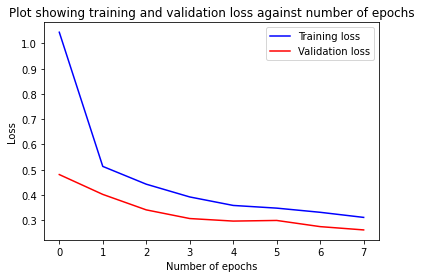

In [14]:
# plot loss curves
x = range(epochs)
plt.title("Plot showing training and validation loss against number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.plot(x, loss_train, color='b', label='Training loss')
plt.plot(x, loss_val, color='r', label='Validation loss')
plt.legend()
plt.savefig('results/T3_loss_curves.png', bbox_inches='tight')
plt.show()

## Visualize results

[]

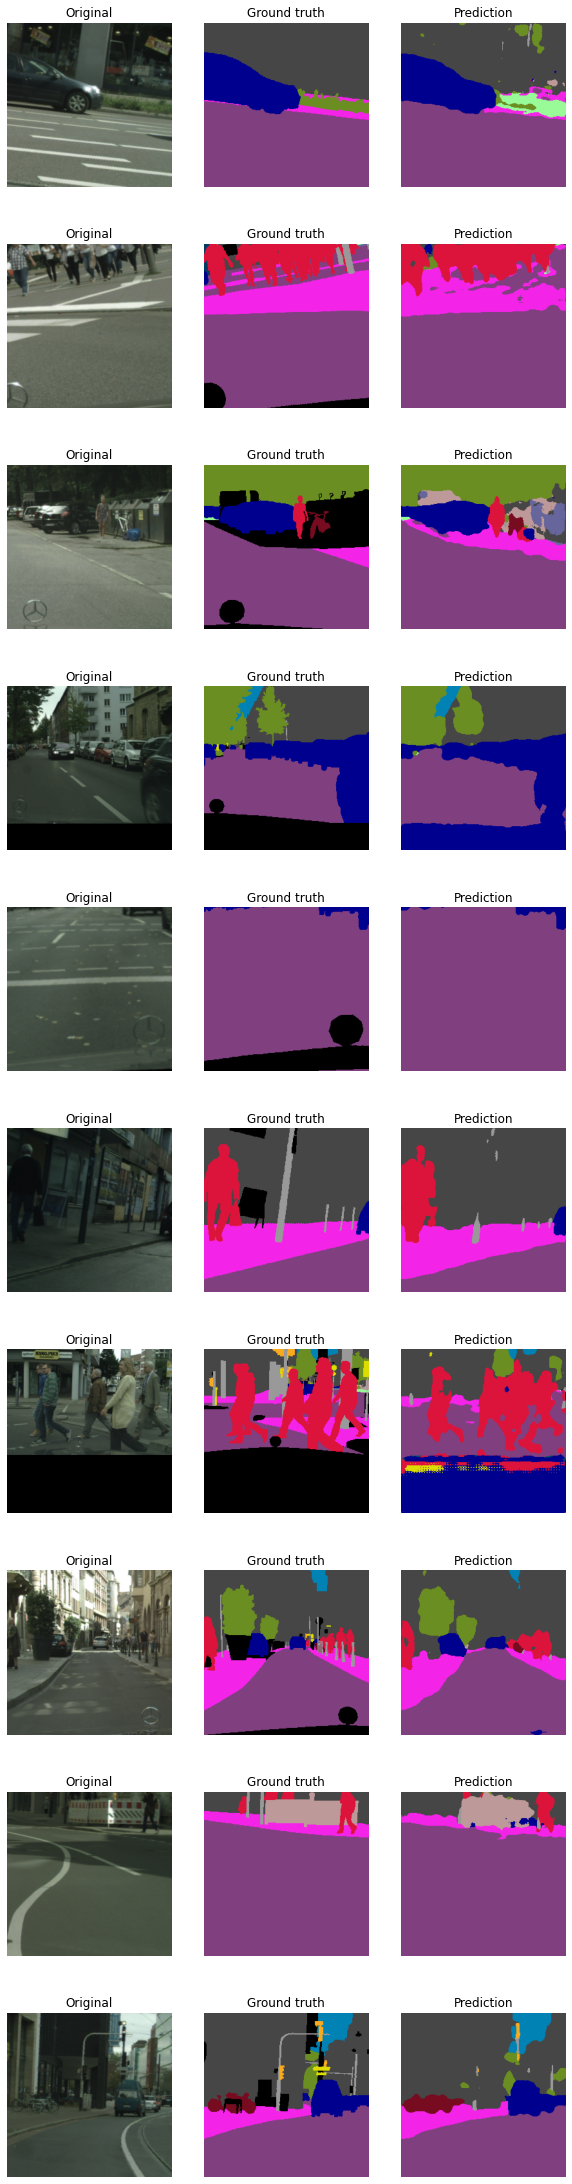

In [12]:

# epochs=1
# move model to gpu
model = model.to(device)
# load the model states
model.load_state_dict(torch.load(f'../weights/T3/epoch_{epochs-1}.pth'))

# model in evaluation model -> batchnorm, dropout etc. adjusted accordingly
model.eval()
# iterator on training data
data = iter(train_loader)
# init figure object
fig = plt.figure(figsize=(10,40))
pred_rgb = list()
# for img, label in trainloader:
for i in range(10):
    sample = next(data) # next batch
    imgs, labels = sample['image'], sample['label']
    # img, label = img.to(device).unsqueeze(0), label.to(device) # to gpu
    # using just one image
    img = imgs[0].to(device).unsqueeze(0) # to gpu & add dummy batch dim
    # gnd = np.asarray(label[0]) 
    # deactivate autograd engine - reduce memory usage 
    with torch.no_grad(): 
        pred = model(img) # forward pass
        # output of model is orderedDict
#         pred = pred['out'] # 21(class)xHxW
        pred = pred.squeeze(0)
        
        # extract most probable class through C-dim 
        pred_label = torch.argmax(pred, dim=0).cpu().numpy()
        # convert labels to color code
#         pred_rgb = dst_train.decode_segmap(pred_label)
        pred_rgb = decode_segmap(pred_label, nc=cls_num, dataset='cityscapes')

        # plotting
        # original image
        fig.add_subplot(10, 3, 3*i+1)
        img = imgs[0].data.cpu().numpy() # data in image and current form of matrix
        img = unNormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # unNormalize
        img = img.transpose((1,2,0)).astype(np.uint8) # change dtype to correct format for display
        plt.title('Original')
        plt.imshow(img) # original
        plt.axis('off')
        # ground truth
        fig.add_subplot(10, 3, 3*i+2)
        label = labels[0].data.numpy() # data in image and current form of matrix
        label = decode_segmap(label, nc=cls_num, dataset='cityscapes')
#         label = dst_train.decode_segmap(label)
        plt.title('Ground truth')
        plt.imshow(label) 
        plt.axis('off')
        # prediction
        fig.add_subplot(10, 3, 3*i+3)
        plt.title('Prediction')
        plt.imshow(pred_rgb.astype(np.uint8))
        plt.axis('off')

plt.savefig('results/T3 results.png', bbox_inches='tight')    
plt.plot()





### Evaluate the model

In [12]:
#5 evaluation matrices to be used: sensitivity, specificity, accuracy, AUC, and DC
from utils.eval_metrics import dice_coefficient_custom, roc_auc_custom, accuracy_se_sp_custom, sensitivity_custom, specificity_custom, iou_custom# user defined
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, multilabel_confusion_matrix

def evaluate_batch(gnd_b, pred_b, cls:int = 34):
    """
        Calculate evalution scores over the batch.
    Args:   
        gnd_b: BxHxW tensor; ground truth labels; each element of matrix in B dim contains class label from (0-20)
        pred_b: BxCxHxW tensor; each element contains predicted class label 
                here C=21 (0-20; no. of classes); each C corresponds to probabilites for that class,
                eg. C=0 contain score at each element in matrix HxW 
    Return:
        f1_score, auc_score, dice_coeeficient (averaged over batch size)
    """
    # to cpu and as numpy ndarray
    gnd_b = gnd_b.cpu()

    batch_size = gnd_b.shape[0]
    
    # extract most probable class through C-dim 
    label_b = torch.argmax(pred_b, dim=1).cpu()
    sensitivity = specificity = accuracy = auc = dice = iou = 0
    # iterate over batch elements
    for i in range(batch_size):
        gnd = gnd_b[i,:,:] 
        label = label_b[i,:,:]
        #f1 += f1_score(gnd.flatten(), label.flatten(), average='micro')
        #sensitivity += sensitivity_custom(gnd, label)
        
        #specificity += specificity_custom(gnd, label)
        #accuracy += accuracy_se_sp_custom(gnd, label)
        temp = accuracy_se_sp_custom(gnd, label)
        accuracy += temp[0]
        sensitivity += temp[1]
        specificity += temp[2]
        # auc += roc_auc_score(gnd.flatten(), label.flatten(), average='micro', multi_class='ovr')
        auc += roc_auc_custom(gnd.numpy(), label.numpy(), cls, average='macro')
        dice += dice_coefficient_custom(gnd.numpy(), label.numpy(), cls)
        iou += iou_custom(gnd.int(), label.int(), cls)

    return [sensitivity/batch_size, specificity/batch_size, accuracy/batch_size, auc/batch_size, dice/batch_size, iou/batch_size]

In [ ]:
# list of score 
sensitivity_list = []
specificity_list = []
accuracy_list = []
auc_list = []
dice_list = []
iou_list = []

# For print
print('Epochs\t Sensitivity-score Specificity-score Accuracy-score ROC-AUC-score\t Dice score\t IOU score')

# move model to gpu
model = model.to(device)
# loop for original number of epochs
for i in range(epochs):
    # load the model states
    model.load_state_dict(torch.load(f'../weights/T3/epoch_{i}.pth'))
    # model in evaluation model -> batchnorm, dropout etc. adjusted accordingly
    model.eval()
    # evaluation score variables to store values over each epoch
    sensitivity_score = specificity_score = accuracy_score = auc_score = dice_score = iou_score = 0


    for sample in val_loader:
        img, label = sample['image'].to(device), sample['label'].to(device)
#         img, label = img.to(device), label.to(device) # to gpu
        # deactivate autograd engine - reduce memory usage 
        with torch.no_grad(): 
            pred = model(img) # forward pass
            # output of model is orderedDict
#             pred = pred['out'] # Batchx21(class)xHxW
            # evaluation
            scores = evaluate_batch(label, pred, cls=cls_num)
            # sum values
            sensitivity_score += scores[0]
            specificity_score += scores[1]
            accuracy_score += scores[2]
            auc_score += scores[3]
            dice_score += scores[4]
            iou_score += scores[5]

    print('{}\t {:.3f}\t\t\t {:.3f}\t\t {:.3f}\t\t {:.3f}\t\t {:.3f}\t\t {:.3f}'.format(i ,sensitivity_score/len(val_loader), specificity_score/len(val_loader), accuracy_score/len(val_loader), auc_score/len(val_loader), dice_score/len(val_loader), iou_score/len(val_loader)))
    # append to list (with averaged values over valid set)
    sensitivity_list.append(sensitivity_score/len(val_loader))
    specificity_list.append(specificity_score/len(val_loader))
    accuracy_list.append(accuracy_score/len(val_loader))
    auc_list.append(auc_score/len(val_loader))
    dice_list.append(dice_score/len(val_loader))
    iou_list.append(iou_score/len(val_loader))



Epochs	 Sensitivity-score Specificity-score Accuracy-score ROC-AUC-score	 Dice score	 IOU score


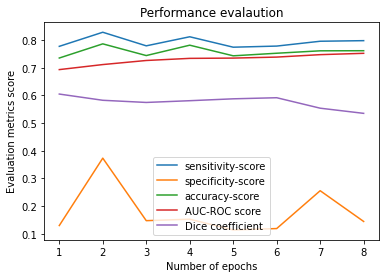

In [18]:
# PLOT
X = range(1, epochs+1)
plt.plot(X, sensitivity_list, label="sensitivity-score")
plt.plot(X, specificity_list, label="specificity-score")
plt.plot(X, accuracy_list, label="accuracy-score")
plt.plot(X, auc_list, label="AUC-ROC score")
plt.plot(X, dice_list, label="Dice coefficient")
plt.xlabel("Number of epochs")
plt.ylabel("Evaluation metrics score")
plt.title("Performance evalaution")
plt.legend() # add legend
plt.savefig('results/T3_eval_metrics.png', bbox_inches='tight')
plt.show()